In [32]:
from datetime import datetime
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import pandas_datareader.data as web
import yfinance as yf

import time

## Step 1. 야후파이낸스 데이터 추출

In [33]:
class YFinance():
    def __init__(self, tickers, period):
        self.period = period
        
        self.df_price = pd.DataFrame()
        self.df_dividends = pd.DataFrame()
        for ticker in tickers:
            print(f'[INFO] 데이터 불러오는 중 .. (ticker : {ticker})')
            full_data = yf.Ticker(ticker).history(start=self.period[0], end=self.period[1])
            self.df_price[ticker] = full_data['Close']
            self.df_dividends[ticker] = full_data['Dividends']
            time.sleep(0.5)
        print(f'[INFO] 데이터셋 구성 완료')
            
    def get_price(self):
        return self.df_price
        
    def get_dividends(self):
        return self.df_dividends

In [426]:
tickers = ['SPY', '^KS11','^TNX', '148070.KS'] # 미국 주식, 한국 주식, 미국 채권, 한국 채권
start_date = '2012-02-28'
end_date = '2022-02-28'

y_finance = YFinance(tickers=tickers, period=(start_date, end_date))

yf_price = y_finance.get_price() # 주가
yf_dividends = y_finance.get_dividends() # 배당금

print('-------------------------------\n',yf_price.shape, yf_dividends.shape)

[INFO] 데이터 불러오는 중 .. (ticker : SPY)
[INFO] 데이터 불러오는 중 .. (ticker : ^KS11)
[INFO] 데이터 불러오는 중 .. (ticker : ^TNX)
[INFO] 데이터 불러오는 중 .. (ticker : 148070.KS)
[INFO] 데이터셋 구성 완료
-------------------------------
 (2518, 4) (2518, 4)


In [427]:
yf_price = yf_price.dropna()
yf_price.columns = ['us_stock','kr_stock','us_bond','kr_bond']

yf_dividends = yf_dividends.dropna()
yf_dividends.columns = yf_price.columns

print(yf_price.shape, yf_dividends.shape)

(2373, 4) (2373, 4)


In [428]:
yf_price

,us_stock,kr_stock,us_bond,kr_bond
Date,,,,
2012-02-28,113.231644,2003.689941,1.929,101140.0
2012-02-29,112.787140,2030.250000,1.977,101085.0
2012-03-02,113.025856,2034.630005,1.986,100890.0
2012-03-05,112.564903,2016.060059,2.005,100680.0
2012-03-06,110.918625,2000.359985,1.944,100640.0
...,...,...,...,...
2022-02-18,432.885193,2744.520020,1.932,115410.0
2022-02-22,428.239624,2706.790039,1.948,115410.0
2022-02-23,420.643219,2719.530029,1.977,115410.0


In [429]:
# 총 누적 배당금
yf_dividends.sum()

us_stock    44.043
kr_stock     0.000
us_bond      0.000
kr_bond      0.000
dtype: float64

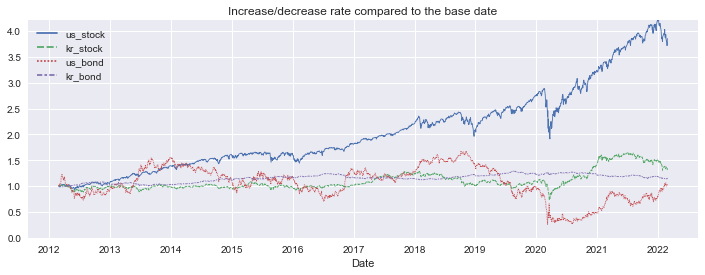

In [430]:
price_rate = yf_price/yf_price.iloc[0] # 기준일(2011-10-20) 대비 증감

plt.figure(figsize=(12,4))
sns.lineplot(data=price_rate, linewidth=0.85)
plt.ylim((0, price_rate.max().max()))
plt.title('Increase/decrease rate compared to the base date')
plt.show()

## Step 2. 일일 수익률 및 최종 수익률 확인

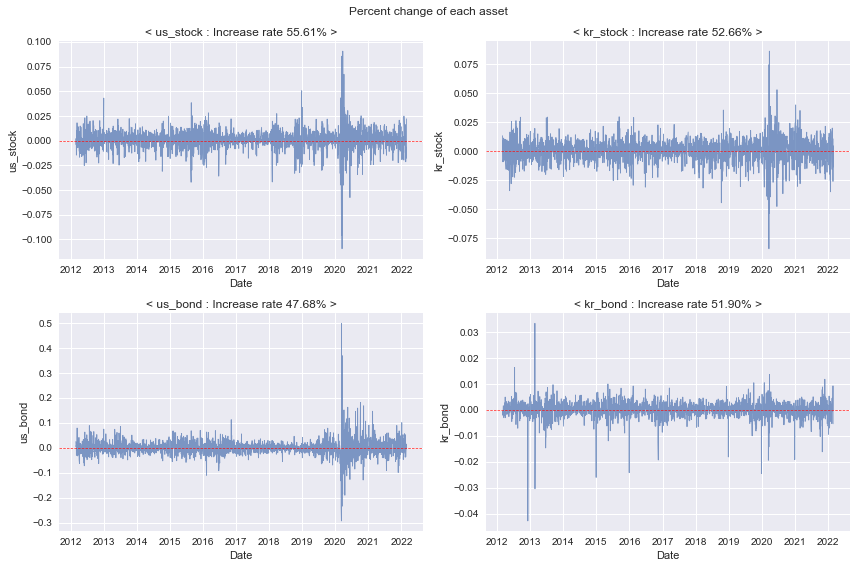

In [432]:
plt.figure(figsize=(12,8))

pcc = yf_price.pct_change().iloc[1:,:] # 첫째 날 데이터 제거(NaN)

for i in range(4):

    data = pcc.iloc[:,i]
    plt.subplot(int(f'22{i+1}'))
    sns.lineplot(data=data, linewidth=0.85, alpha=0.7)
    inc_rate = (data > 0).sum() / len(data) * 100
    plt.title(f'< {data.name} : Increase rate {inc_rate:.2f}% >')
    plt.axhline(y=0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)

plt.suptitle('Percent change of each asset')
plt.tight_layout()
plt.show()

In [90]:
# 총 수익률
return_rate = ((yf_price.iloc[-1] + yf_dividends.sum()) / yf_price.iloc[0] - 1) * 100
return_rate

us_stock    383.704728
kr_stock     49.772037
us_bond     -14.449543
kr_bond      16.597531
dtype: float64

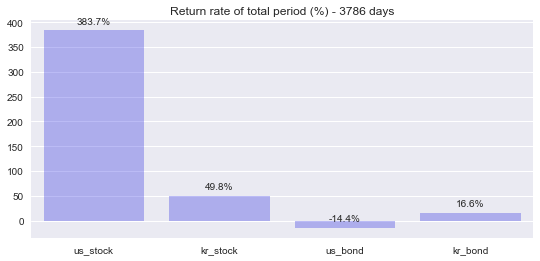

In [118]:
plt.figure(figsize=(9,4))
bars = sns.barplot(x=return_rate.index, y=return_rate.values, color='Blue', alpha=0.3)
for p in bars.patches:
    bars.annotate(f'{p.get_height():.1f}%',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va='center',
                   xytext = (0,9),
                   textcoords = 'offset points')
    
plt.title(f'Return rate of total period (%) - {(yf_price.index[-1] - yf_price.index[0]).days} days')
plt.show()

## Step 3. 일일 수익률 상관관계 시각화

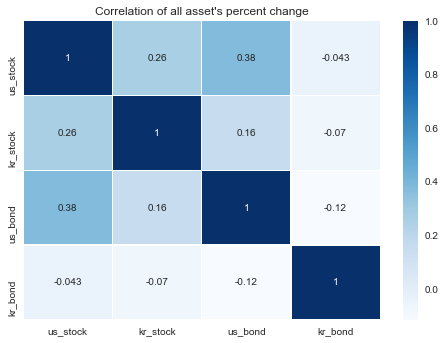

In [433]:
plt.title("Correlation of all asset's percent change")
sns.heatmap(yf_price.pct_change().corr(), cmap='Blues', linewidth=0.2, annot=True)
plt.show()

## Step 4. 변동성(위험) 대비 수익률 시각화

In [541]:
import numpy as np

port_ratios = []
port_returns = np.array([])
port_risks = np.array([])
for i in range(10000): # 포트폴리오 비율 조합 1000개
    # 포트폴리오 비율
    port_ratio = np.random.rand(len(yf_price.columns)) # 4가지 랜덤 실수 조합
    port_ratio /= port_ratio.sum() # 합계가 1인 랜덤 실수
    port_ratios.append(port_ratio)
    
    # 연 평균 수익률
    total_return_rate = (yf_price.iloc[-1] + yf_dividends.sum()) / yf_price.iloc[0] # 배당금 합산 총 수익률(%)
    annual_avg_rr = total_return_rate ** (1/10) # 연 (기하)평균 수익률(%)
    port_return = np.dot(port_ratio, annual_avg_rr-1) # 연 평균 포트폴리오 수익률 = 연 평균 수익률과 포트폴리오 비율의 행렬곱
    port_returns = np.append(port_returns, port_return)
    
    # 연간 수익률 공분산
    annual_cov = yf_price.pct_change().cov() * len(yf_price)/10 # 연간 수익률의 공분산 = 일별 수익률 공분산 * 연간 평균 거래일수
    port_risk = np.sqrt(np.dot(port_ratio.T, np.dot(annual_cov, port_ratio))) # E(Volatility) = sqrt(WT*COV*W)
    port_risks = np.append(port_risks, port_risk)

In [584]:
sorted_shape_idx = np.argsort(port_returns/port_risks)
sorted_risk_idx = np.argsort(port_risks)

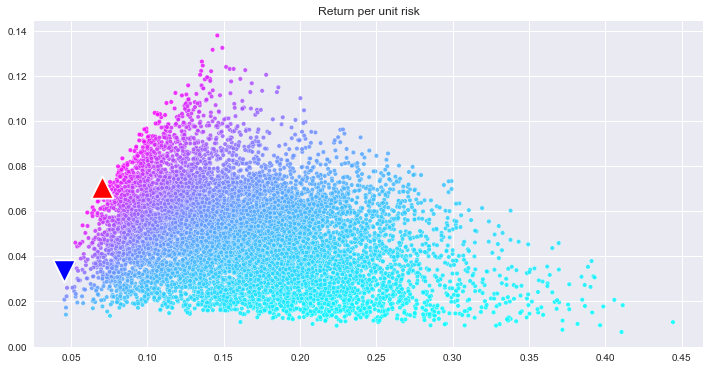

In [585]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=port_risks, y=port_returns, c=port_returns/port_risks, cmap='cool', alpha=0.85, s=20)
sns.scatterplot(x=port_risks[sorted_shape_idx[-1:]], y=port_returns[sorted_shape_idx[-1:]], color='r', marker='^', s=500)
sns.scatterplot(x=port_risks[sorted_risk_idx[:1]], y=port_returns[sorted_risk_idx[:1]], color='b', marker='v', s=500)

plt.title('Return per unit risk')
plt.show()

## Step 5. 샤프지수에 따른 포트폴리오 비율 시각화

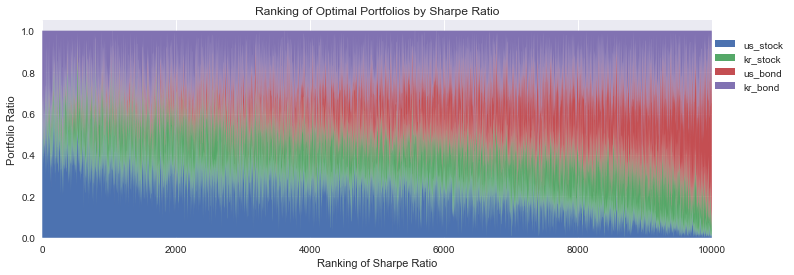

In [692]:
port_df = pd.DataFrame(port_ratios)
sorted_port_df = port_df.iloc[sorted_shape_idx[::-1]] # 역순
sorted_port_df.columns = yf_price.columns

plt.figure(figsize=(12,4))
plt.stackplot(np.arange(1,len(sorted_port_df)+1,1), np.array(sorted_port_df.T), labels=sorted_port_df.columns)

plt.xlim(0,10000)
plt.legend(bbox_to_anchor=(1.12,0.95))
plt.xlabel('Ranking of Sharpe Ratio')
plt.ylabel('Portfolio Ratio')
plt.title('Ranking of Optimal Portfolios by Sharpe Ratio')
plt.show()

## Step 6. 샤프지수에 따른 포트폴리오 수익률 및 변동성 시각화

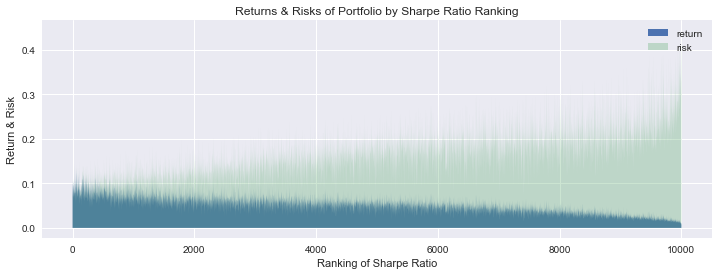

In [693]:
sorted_returns = port_returns[[sorted_port_df.index]]
sorted_risks = port_risks[[sorted_port_df.index]]

plt.figure(figsize=(12,4))
plt.fill_between(x=np.arange(1,len(sorted_returns)+1,1), y1=sorted_returns.tolist(), label='return')
plt.fill_between(x=np.arange(1,len(sorted_risks)+1,1), y1=sorted_risks.tolist(), alpha=0.3, label='risk')
plt.xlabel('Ranking of Sharpe Ratio')
plt.ylabel('Return & Risk')
plt.title('Returns & Risks of Portfolio by Sharpe Ratio Ranking')
plt.legend()
plt.show()

In [694]:
print(f'최적의 포트폴리오 비율 : \n{pd.Series(sorted_port_df.iloc[0], index=sorted_port_df.columns)}')


최적의 포트폴리오 비율 : 
us_stock    0.400854
kr_stock    0.021281
us_bond     0.000041
kr_bond     0.577824
Name: 664, dtype: float64
